# Objective:
## Classifying sentences from internet forms and real-life speech from TV shows to the six basic emotions (Happiness, Sadness, Disgust, Anger, Fear, and Surprise)

### Model based on BERT

# BERT-Based Emotion Classification

## Model Overview:
- **Approach**: Fine-tunes a pre-trained BERT model (bert-base-uncased) for emotion classification.
- **Embeddings**: Leverages BERT’s contextual embeddings to classify input text into emotion categories.
- **Target Encoding**: Emotion labels are encoded using LabelEncoder.
- **Data**: Training data is balanced.

## Training Details:
- **Tokenization & Padding**:  
  - Text is tokenized using the BERT tokenizer.
  - Sequences are padded to a maximum length of 128 tokens.
- **Optimizer**: Adam with a learning rate of 2e-5.
- **Epochs**: 10
- **Batch Size**: 16
- **Model Architecture**:  
  - Utilizes the TFBertForSequenceClassification model.
  - Number of output labels is set according to the number of emotion classes.

## Performance Highlights:
- **Overall Test Accuracy**: ~86.13%
- **Weighted Metrics**:  
  - Precision: ~86%
  - Recall: ~86%
  - F1 Score: ~86%
- **Classification Report**:  
  - Strong performance across all emotion classes (anger, disgust, fear, happiness, neutral, sadness, surprise) with high precision, recall, and F1 scores.
- **Confusion Matrix**:  
  - Indicates effective differentiation between emotion classes with minimal misclassifications.


### Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

2025-04-02 21:24:50.018781: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 21:24:50.057163: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-02 21:24:50.057199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-02 21:24:50.059159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 21:24:50.066618: I tensorflow/core/platform/cpu_feature_guar

### Parameters

In [ ]:
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 10
BERT_MODEL_NAME = "bert-base-uncased"
LEARNING_RATE = 2e-5

### Load and Process Data

In [ ]:
df = pd.read_csv("train_balanced_new_via_task4.csv")
df = df.dropna(subset=["Emotion"])

# Encode target labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Emotion"])
num_labels = len(label_encoder.classes_)
np.save("label_classes.npy", label_encoder.classes_)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

def encode_texts(texts):
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )
    return encodings["input_ids"], encodings["attention_mask"]

input_ids, attention_masks = encode_texts(df["text"])
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()

# Split into Train, Validation, and Test Sets
train_ids, temp_ids, train_masks, temp_masks, train_labels, temp_labels = train_test_split(
    input_ids, attention_masks, df["label"].values, test_size=0.2, random_state=42
)

val_ids, test_ids, val_masks, test_masks, val_labels, test_labels = train_test_split(
    temp_ids, temp_masks, temp_labels, test_size=0.5, random_state=42
)


2025-04-02 21:25:18.907302: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-04-02 21:25:18.907636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46672 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:21:00.0, compute capability: 8.9


### Build the BERT Model

In [ ]:

def build_model(num_labels):
    input_ids_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids")
    attention_mask_layer = tf.keras.layers.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_mask")
    
    bert_model = TFBertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, num_labels=num_labels)
    logits = bert_model(input_ids_layer, attention_mask=attention_mask_layer)[0]
    
    model = tf.keras.Model(inputs=[input_ids_layer, attention_mask_layer], outputs=logits)
    return model

model = build_model(num_labels)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Train the model

In [ ]:

history = model.fit(
    [train_ids, train_masks], train_labels,
    validation_data=([val_ids, val_masks], val_labels),
    epochs=EPOCHS, batch_size=BATCH_SIZE
)


Epoch 1/10


2025-04-02 21:26:08.879604: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f976cf4ece0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-02 21:26:08.879628: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-04-02 21:26:08.884755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-02 21:26:08.912898: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1743629169.008085  805906 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3496/3496 [==============================] - 331s 79ms/step - loss: 0.9489 - accuracy: 0.6737 - val_loss: 0.6786 - val_accuracy: 0.7750
Epoch 2/10
3496/3496 [==============================] - 257s 74ms/step - loss: 0.5022 - accuracy: 0.8379 - val_loss: 0.5212 - val_accuracy: 0.8375
Epoch 3/10
3496/3496 [==============================] - 257s 74ms/step - loss: 0.3048 - accuracy: 0.9048 - val_loss: 0.5059 - val_accuracy: 0.8517
Epoch 4/10
3496/3496 [==============================] - 259s 74ms/step - loss: 0.2154 - accuracy: 0.9318 - val_loss: 0.5304 - val_accuracy: 0.8585
Epoch 5/10
3496/3496 [==============================] - 255s 73ms/step - loss: 0.1754 - accuracy: 0.9433 - val_loss: 0.5544 - val_accuracy: 0.8598
Epoch 6/10
3496/3496 [==============================] - 254s 73ms/step - loss: 0.1511 - accuracy: 0.9487 - val_loss: 0.5501 - val_accuracy: 0.8650
Epoch 7/10
3496/3496 [==============================] - 254s 73ms/step - loss: 0.1322 - accuracy: 0.9538 - val_loss: 0.5941 - val

### Visualize Training Metrics


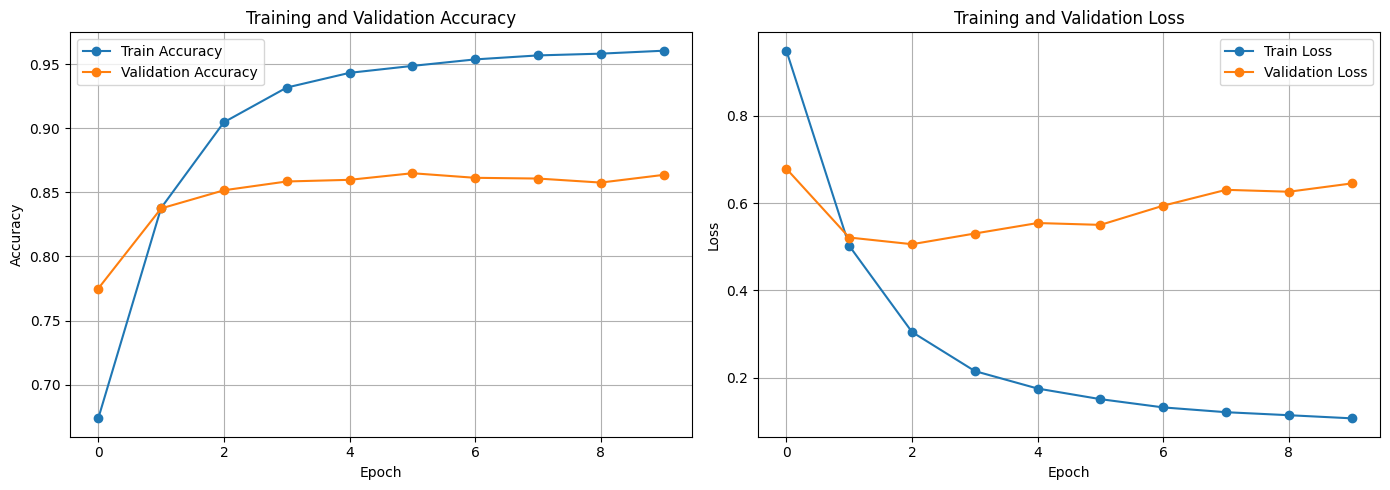

In [ ]:

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], marker='o', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], marker='o', label='Train Loss')
plt.plot(history.history['val_loss'], marker='o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Evaluate Model

219/219 [==============================] - 16s 41ms/step

Test Set Evaluation Metrics:
Accuracy: 0.8613
Precision: 0.8614
Recall: 0.8613
F1 Score: 0.8602

Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.94      0.93      1014
     disgust       0.86      0.72      0.78       990
        fear       0.82      0.81      0.81      1003
   happiness       0.90      0.92      0.91       969
     neutral       0.81      0.85      0.83       994
     sadness       0.93      0.96      0.94      1005
    surprise       0.80      0.84      0.82      1016

    accuracy                           0.86      6991
   macro avg       0.86      0.86      0.86      6991
weighted avg       0.86      0.86      0.86      6991



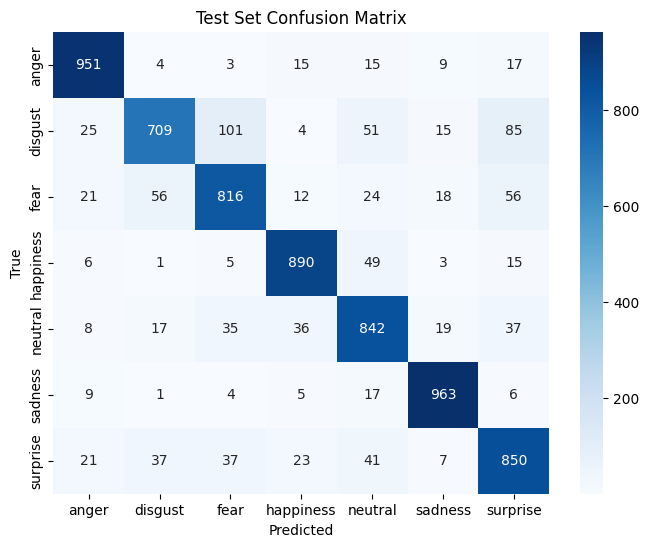

In [ ]:
y_test_pred_logits = model.predict([test_ids, test_masks])
y_test_pred = np.argmax(y_test_pred_logits, axis=1)
test_pred_labels = label_encoder.inverse_transform(y_test_pred)
test_true_labels = label_encoder.inverse_transform(test_labels)

# Compute Metrics
accuracy = accuracy_score(test_true_labels, test_pred_labels)
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

print(f"\nTest Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print Classification Report
print("\nClassification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=label_encoder.classes_))

# ------------------------------

cm = confusion_matrix(test_true_labels, test_pred_labels, labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Test Set Confusion Matrix")
plt.show()